In [27]:
import pandas as pd
import numpy as np

# Define the path to the CSV file
league = "premier-league"
forecasts_csv_path = f"./{league}_forecasts_all.csv"

data = pd.read_csv(forecasts_csv_path, header=None)

# The first row contains player names, and the second row contains scores
# We'll create a DataFrame using the first row for column names and the second row for data
player_names = data.iloc[0, :].values
expected_scores = data.iloc[1, :].values
upper_bound = data.iloc[2, :].values
lower_bound = data.iloc[3, :].values

# Create a DataFrame from these arrays
vertical_df = pd.DataFrame({
    "Player Name": player_names,
    "Lower Bound": lower_bound,
    "Expected Score": expected_scores,
    "Upper Bound": upper_bound
})
vertical_df['Expected Score'] = pd.to_numeric(vertical_df['Expected Score'][1:])
vertical_df['Upper Bound'] = pd.to_numeric(vertical_df['Upper Bound'][1:])
vertical_df['Lower Bound'] = pd.to_numeric(vertical_df['Lower Bound'][1:])
vertical_df.loc[vertical_df['Expected Score'] > 100, 'Expected Score'] = 100
vertical_df.loc[vertical_df['Upper Bound'] > 100, 'Upper Bound'] = 100

# Now sort the DataFrame by 'Expected Score' in descending order
vertical_df = vertical_df[1:]
vertical_df.sort_values(by="Expected Score", ascending=False, inplace=True)
vertical_df

,Player Name,Lower Bound,Expected Score,Upper Bound
302,marcos-senesi,66.752040,100.00000,100.000000
242,jordan-ayew,61.276369,100.00000,99.075008
461,trent-alexander-arnold,65.169013,100.00000,100.000000
125,dejan-kulusevski,109.092857,100.00000,100.000000
379,pascal-gross,100.000000,100.00000,100.000000
...,...,...,...,...
451,tim-krul,3.700000,3.70000,95.200000
228,joao-manuel-neves-virginia,0.000000,3.43521,13.060375
426,scott-mctominay,0.000000,0.00000,18.297818
265,kieran-trippier,0.000000,0.00000,31.007178


In [28]:
import os
import json

# Define the path to the clubs directory
clubs_dir_path = "./data/" + league + "/clubs"

# Initialize dictionaries to map player slugs to their club names, positions, last scores, and L9 average scores
player_club_mapping = {}
player_position_mapping = {}
player_last_score_mapping = {}
player_l9_average_mapping = {}

# Iterate over each file in the clubs directory
for filename in os.listdir(clubs_dir_path):
    if filename.endswith(".json"):
        # Extract club name from the filename
        club_name = filename[:-5]  # Remove '.json' extension
        
        # Load the JSON file
        with open(os.path.join(clubs_dir_path, filename)) as f:
            club_data = json.load(f)
        
        # Iterate over the players in the JSON file
        for player in club_data["football"]["club"]["activePlayers"]["nodes"]:
            player_slug = player["slug"]
            # Map the player slug to the club name
            player_club_mapping[player_slug] = club_name
            # Also map the player slug to their position
            player_position_mapping[player_slug] = player.get("position", "Unknown")
            
            # Extract the last score for the player (assuming the first score is the most recent one)
            if player.get("so5Scores"):
                last_score = player["so5Scores"][0].get("score", 0)
                # Calculate L9 as the average of the rest excluding zeros
                rest_scores = [score["score"] for score in player["so5Scores"][1:] if score["score"] != 0]
                l9_average = sum(rest_scores) / len(rest_scores) if rest_scores else 0
            else:
                last_score = 0
                l9_average = 0
            
            player_last_score_mapping[player_slug] = last_score
            player_l9_average_mapping[player_slug] = l9_average

# For each player in the vertical_df, find their club name, position, last score, and L9 average using the mappings
vertical_df['Club'] = vertical_df['Player Name'].map(player_club_mapping)
vertical_df['Position'] = vertical_df['Player Name'].map(player_position_mapping)
vertical_df['Last Score'] = vertical_df['Player Name'].map(player_last_score_mapping)
vertical_df['L9'] = vertical_df['Player Name'].map(player_l9_average_mapping)
risk = vertical_df['Expected Score'] - vertical_df['Lower Bound']
reward = vertical_df['Upper Bound'] - vertical_df['Expected Score']
vertical_df['Risk-Reward Ratio'] = np.where(risk != 0, reward / risk, np.nan)
k = 2 # Adjust based on your risk tolerance
vertical_df['HRHR'] = k * reward - (1/k) * risk
for col in vertical_df.columns:
    if vertical_df[col].dtype == 'float64':  # Check if the column is of float dtype
        # Convert to numeric, coercing errors, which turns problematic values to NaN
        vertical_df[col] = vertical_df[col].round()


In [29]:
vertical_df

,Player Name,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,Risk-Reward Ratio,HRHR
302,marcos-senesi,67.0,100.0,100.0,afc-bournemouth-bournemouth-dorset,Defender,41.0,54.0,0.0,-17.0
242,jordan-ayew,61.0,100.0,99.0,crystal-palace-london,Forward,43.0,61.0,-0.0,-21.0
461,trent-alexander-arnold,65.0,100.0,100.0,liverpool-liverpool,Defender,0.0,56.0,0.0,-17.0
125,dejan-kulusevski,109.0,100.0,100.0,tottenham-hotspur-london,Forward,49.0,44.0,-0.0,5.0
379,pascal-gross,100.0,100.0,100.0,brighton-hove-albion-brighton-east-sussex,Midfielder,25.0,80.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
451,tim-krul,4.0,4.0,95.0,luton-town-luton-bedfordshire,Goalkeeper,0.0,0.0,NaN,183.0
228,joao-manuel-neves-virginia,0.0,3.0,13.0,everton-liverpool,Goalkeeper,0.0,0.0,3.0,18.0
426,scott-mctominay,0.0,0.0,18.0,manchester-united-manchester,Midfielder,33.0,42.0,NaN,37.0
265,kieran-trippier,0.0,0.0,31.0,newcastle-united-newcastle-upon-tyne,Defender,33.0,61.0,NaN,62.0


In [4]:
# Define the path where you want to save the Excel file
final_excel_path = f"./{league}_final_forecasts_with_clubs.xlsx"

# Export the DataFrame to an Excel file
vertical_df.to_excel(final_excel_path, index=False)

# If you want to verify or inform that the file has been saved, you could print a confirmation message.
print(f"Final DataFrame saved to {final_excel_path}")


Final DataFrame saved to ./ligue-1-fr_final_forecasts_with_clubs.xlsx


In [36]:
filtered_df = vertical_df[(vertical_df['Club'] != "sheffield-united-sheffield") & (vertical_df['Club'] != "arsenal-london")]
# filtered_df = vertical_df
filtered_df

,Player Name,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,Risk-Reward Ratio,HRHR
302,marcos-senesi,67.0,100.0,100.0,afc-bournemouth-bournemouth-dorset,Defender,41.0,54.0,0.0,-17.0
242,jordan-ayew,61.0,100.0,99.0,crystal-palace-london,Forward,43.0,61.0,-0.0,-21.0
461,trent-alexander-arnold,65.0,100.0,100.0,liverpool-liverpool,Defender,0.0,56.0,0.0,-17.0
125,dejan-kulusevski,109.0,100.0,100.0,tottenham-hotspur-london,Forward,49.0,44.0,-0.0,5.0
379,pascal-gross,100.0,100.0,100.0,brighton-hove-albion-brighton-east-sussex,Midfielder,25.0,80.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
451,tim-krul,4.0,4.0,95.0,luton-town-luton-bedfordshire,Goalkeeper,0.0,0.0,NaN,183.0
228,joao-manuel-neves-virginia,0.0,3.0,13.0,everton-liverpool,Goalkeeper,0.0,0.0,3.0,18.0
426,scott-mctominay,0.0,0.0,18.0,manchester-united-manchester,Midfielder,33.0,42.0,NaN,37.0
265,kieran-trippier,0.0,0.0,31.0,newcastle-united-newcastle-upon-tyne,Defender,33.0,61.0,NaN,62.0


In [37]:
import numpy as np
import pandas as pd

filtered_df = filtered_df[(filtered_df['Last Score'] != 0)]

# Function to calculate SMAPE
def calculate_smape(expected, actual):
    return 100 * np.abs(expected - actual) / ((np.abs(actual) + np.abs(expected)) / 2)

# Function to calculate absolute deviation
def calculate_deviation(expected, actual):
    return np.abs(actual - expected)

# Calculate SMAPE and Deviation for each player
metric_for_smape = "Expected Score"
filtered_df['SMAPE'] = calculate_smape(filtered_df[metric_for_smape], filtered_df['Last Score'])
filtered_df['Deviation'] = calculate_deviation(filtered_df[metric_for_smape], filtered_df['Last Score'])

# Calculate whether scores are within bounds
filtered_df['Within Bounds'] = filtered_df.apply(lambda row: row['Lower Bound'] <= row['Last Score'] <= row['Upper Bound'], axis=1)

# Calculate the percentages
within_bounds_percentage = (filtered_df['Within Bounds'].mean()) * 100
outside_bounds_percentage = 100 - within_bounds_percentage

# Calculate the total average SMAPE and Deviation
total_average_smape = filtered_df['SMAPE'].mean()
total_average_deviation = filtered_df['Deviation'].mean()

# Categorize Expected Score into classes
bins = np.arange(0, 110, 10)
labels = [f"{i}-{i+10}" for i in range(0, 100, 10)]
filtered_df['Score Class'] = pd.cut(filtered_df['Expected Score'], bins=bins, labels=labels, right=False)

# Group by score class and calculate average SMAPE and Deviation for each class
grouped_stats = filtered_df.groupby('Score Class')[['SMAPE', 'Deviation']].mean()
for col in filtered_df.columns:
    if filtered_df[col].dtype == 'float64':  # Check if the column is of float dtype
        # Convert to numeric, coercing errors, which turns problematic values to NaN
        filtered_df[col] = filtered_df[col].round()

# Print the results
print(f"Total Average SMAPE: {total_average_smape}%")
print(f"Total Average Deviation: {total_average_deviation}")
print(f"Percentage of Real Scores Correctly Between the Bounds: {within_bounds_percentage}%")
print(f"Percentage of Real Scores Not Between the Bounds: {outside_bounds_percentage}%")
print("SMAPE and Deviation by Score Class:")
print(grouped_stats)


Total Average SMAPE: 41.415798544183765%
Total Average Deviation: 19.19455252918288
Percentage of Real Scores Correctly Between the Bounds: 61.08949416342413%
Percentage of Real Scores Not Between the Bounds: 38.91050583657587%
SMAPE and Deviation by Score Class:
                  SMAPE  Deviation
Score Class                       
0-10         159.090909  28.250000
10-20         79.673532  27.750000
20-30         35.458918  13.833333
30-40         36.582699  15.864407
40-50         36.401341  17.225806
50-60         34.666153  17.489362
60-70         39.828228  20.037037
70-80         54.896072  29.875000
80-90         56.240515  33.000000
90-100        66.020653  47.000000


C:\Users\alexa\AppData\Local\Temp\ipykernel_43420\2209759899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['SMAPE'] = calculate_smape(filtered_df[metric_for_smape], filtered_df['Last Score'])
C:\Users\alexa\AppData\Local\Temp\ipykernel_43420\2209759899.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Deviation'] = calculate_deviation(filtered_df[metric_for_smape], filtered_df['Last Score'])
C:\Users\alexa\AppData\Local\Temp\ipykernel_43420\2209759899.py:20: SettingWithCop

In [40]:
filtered_df.sort_values(by="Expected Score", ascending=False, inplace=True)
filtered_df

C:\Users\alexa\AppData\Local\Temp\ipykernel_43420\3117380888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by="Expected Score", ascending=False, inplace=True)


,Player Name,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,Risk-Reward Ratio,HRHR,SMAPE,Deviation,Within Bounds,Score Class
302,marcos-senesi,67.0,100.0,100.0,afc-bournemouth-bournemouth-dorset,Defender,41.0,54.0,0.0,-17.0,84.0,59.0,False,NaN
242,jordan-ayew,61.0,100.0,99.0,crystal-palace-london,Forward,43.0,61.0,-0.0,-21.0,80.0,57.0,False,NaN
125,dejan-kulusevski,109.0,100.0,100.0,tottenham-hotspur-london,Forward,49.0,44.0,-0.0,5.0,68.0,51.0,False,NaN
379,pascal-gross,100.0,100.0,100.0,brighton-hove-albion-brighton-east-sussex,Midfielder,25.0,80.0,NaN,0.0,120.0,75.0,False,NaN
277,lewis-dunk,73.0,100.0,100.0,brighton-hove-albion-brighton-east-sussex,Defender,45.0,59.0,0.0,-14.0,76.0,55.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,andrew-omobamidele,10.0,10.0,10.0,nottingham-forest-nottingham,Defender,76.0,31.0,NaN,0.0,153.0,66.0,False,10-20
469,victor-alexander-da-silva,9.0,9.0,0.0,burnley-burnley-lancashire,Defender,13.0,33.0,NaN,-19.0,36.0,4.0,False,0-10
426,scott-mctominay,0.0,0.0,18.0,manchester-united-manchester,Midfielder,33.0,42.0,NaN,37.0,200.0,33.0,False,0-10
265,kieran-trippier,0.0,0.0,31.0,newcastle-united-newcastle-upon-tyne,Defender,33.0,61.0,NaN,62.0,200.0,33.0,False,0-10


In [41]:
import numpy as np

# Assuming the previous steps have been completed and filtered_df is ready

# Group the filtered DataFrame by 'Club' and calculate the mean SMAPE for each club
smape_per_club = filtered_df.groupby('Club')['SMAPE'].mean()
deviation_per_club = filtered_df.groupby('Club')['Deviation'].mean()

# Print the SMAPE for each club
print("SMAPE per Club:")
print(smape_per_club)
print("\nDeviation per Club:")
print(deviation_per_club)


SMAPE per Club:
Club
afc-bournemouth-bournemouth-dorset           34.687500
aston-villa-birmingham                       27.187500
brentford-brentford-middlesex                31.461538
brighton-hove-albion-brighton-east-sussex    60.000000
burnley-burnley-lancashire                   42.533333
chelsea-london                               31.769231
crystal-palace-london                        52.071429
everton-liverpool                            35.785714
fulham-london                                45.375000
liverpool-liverpool                          50.307692
luton-town-luton-bedfordshire                32.428571
manchester-city-manchester                   36.583333
manchester-united-manchester                 57.416667
newcastle-united-newcastle-upon-tyne         51.733333
nottingham-forest-nottingham                 47.307692
tottenham-hotspur-london                     39.125000
west-ham-united-london                       41.866667
wolverhampton-wanderers-wolverhampton       

In [42]:
filtered_df["Exp_AVG"] = (filtered_df["Expected Score"] + filtered_df["Upper Bound"]) / 2

C:\Users\alexa\AppData\Local\Temp\ipykernel_43420\3284370669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Exp_AVG"] = (filtered_df["Expected Score"] + filtered_df["Upper Bound"]) / 2


Risk-Reward Ratio
Pearson Correlation Coefficient: -0.11, P-value: 0.08
Spearman Correlation Coefficient: -0.09, P-value: 0.18
Average Last Score per Player: 46.1
Average 'Last Score' per Club (for top 5 players): 230.28

Last Score for each Club (top 5 players):
Club
afc-bournemouth-bournemouth-dorset           267.0
aston-villa-birmingham                       234.0
brentford-brentford-middlesex                236.0
brighton-hove-albion-brighton-east-sussex    175.0
burnley-burnley-lancashire                   192.0
chelsea-london                               259.0
crystal-palace-london                        153.0
everton-liverpool                            146.0
fulham-london                                248.0
liverpool-liverpool                          263.0
luton-town-luton-bedfordshire                163.0
manchester-city-manchester                   349.0
manchester-united-manchester                 187.0
newcastle-united-newcastle-upon-tyne         274.0
nottingham-forest

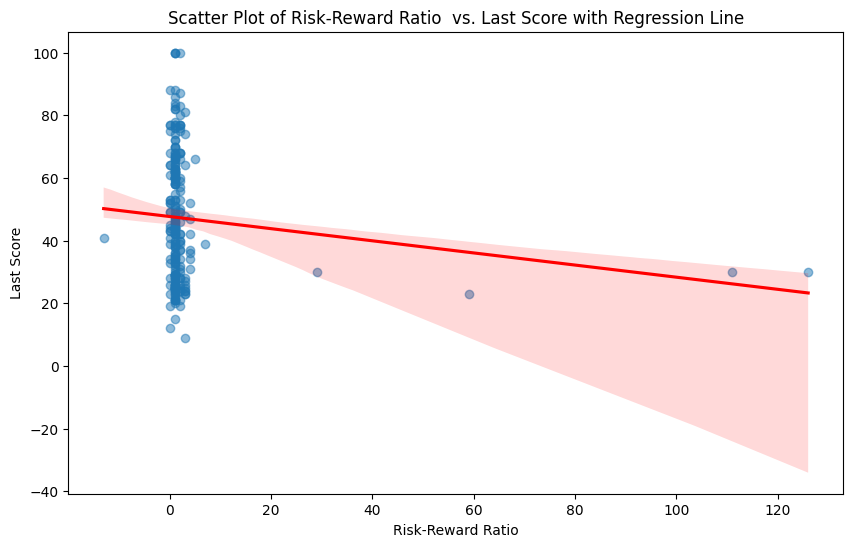

In [49]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming vertical_df is your DataFrame and necessary calculations like SMAPE have been done
filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
filtered_df = filtered_df.dropna(subset=['Risk-Reward Ratio'])  # Drop rows with NaN in 'Risk-Reward Ratio'

# Pearson Correlation
metric = "Risk-Reward Ratio"
print(metric)
pearson_corr = scipy.stats.pearsonr(filtered_df[metric], filtered_df['Last Score'])
print(f"Pearson Correlation Coefficient: {round(pearson_corr[0], 2)}, P-value: {round(pearson_corr[1], 2)}")

# Spearman Correlation
spearman_corr = scipy.stats.spearmanr(filtered_df[metric], filtered_df['Last Score'])
print(f"Spearman Correlation Coefficient: {round(spearman_corr[0], 2)}, P-value: {round(spearman_corr[1], 2)}")

# Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x=metric, y='Last Score', data=filtered_df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Scatter Plot of ' + metric + '  vs. Last Score with Regression Line')
plt.xlabel(metric)
plt.ylabel('Last Score')

top_players_per_club = filtered_df.groupby('Club').apply(lambda x: x.nlargest(5, metric))
# Reset index to avoid MultiIndex after groupby
top_players_per_club = top_players_per_club.reset_index(drop=True)
# Calculate the total 'Last Score' of the selected players
average_last_score_per_player = top_players_per_club['Last Score'].mean()
print(f"Average Last Score per Player: {round(average_last_score_per_player, 1)}")

# Group by 'Club', sum 'Last Score' for the top 5 players in each club, then calculate the average of these sums
average_last_score_per_club = top_players_per_club.groupby('Club')['Last Score'].sum().mean()
print(f"Average 'Last Score' per Club (for top 5 players): {round(average_last_score_per_club, 2)}")
club_scores = top_players_per_club.groupby('Club')['Last Score'].sum()
print("\nLast Score for each Club (top 5 players):")
print(club_scores)

plt.show()

In [45]:
top_players_per_club

,Player Name,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,Risk-Reward Ratio,HRHR,SMAPE,Deviation,Within Bounds,Score Class,Exp_AVG
0,marcos-senesi,67.0,100.0,100.0,afc-bournemouth-bournemouth-dorset,Defender,41.0,54.0,0.0,-17.0,84.0,59.0,False,NaN,100.0
1,milos-kerkez,39.0,55.0,71.0,afc-bournemouth-bournemouth-dorset,Defender,67.0,34.0,1.0,24.0,20.0,12.0,True,50-60,63.0
2,norberto-murara-neto,33.0,50.0,66.0,afc-bournemouth-bournemouth-dorset,Goalkeeper,78.0,41.0,1.0,23.0,44.0,28.0,False,50-60,58.0
3,illia-zabarnyi,35.0,47.0,65.0,afc-bournemouth-bournemouth-dorset,Defender,48.0,45.0,1.0,29.0,2.0,1.0,True,40-50,56.0
4,adam-smith-1991-04-29,22.0,42.0,64.0,afc-bournemouth-bournemouth-dorset,Defender,62.0,42.0,1.0,35.0,38.0,20.0,True,40-50,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,daniel-bentley,9.0,81.0,100.0,wolverhampton-wanderers-wolverhampton,Goalkeeper,26.0,0.0,0.0,2.0,103.0,55.0,True,80-90,90.5
86,craig-dawson,33.0,68.0,100.0,wolverhampton-wanderers-wolverhampton,Defender,43.0,62.0,1.0,45.0,45.0,25.0,True,60-70,84.0
87,mario-lemina,37.0,57.0,78.0,wolverhampton-wanderers-wolverhampton,Midfielder,47.0,63.0,1.0,31.0,19.0,10.0,True,50-60,67.5
88,max-kilman,57.0,56.0,65.0,wolverhampton-wanderers-wolverhampton,Defender,41.0,57.0,-13.0,18.0,31.0,15.0,False,50-60,60.5
